In [34]:
import pandas as pd
from matplotlib import pyplot as pp
import numpy as np
import datetime

In [35]:
df = pd.read_pickle("../recording.pkl")
df.reset_index(inplace=True)

# shortcuts
channel = ["channel{}".format(i) for i in range(8)]
highlighted = ["highlighted{}".format(i) for i in range(30)]
interval = "interval"
target = "target"
df.head()

,timestamp,channel0,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8,...,highlighted22,highlighted23,highlighted24,highlighted25,highlighted26,highlighted27,highlighted28,highlighted29,interval,target
0,2017-12-18 12:01:54.531734,-22,0,10,1230,2481,2527,2563,2568,2572,...,False,False,False,False,False,False,False,False,0,NaN
1,2017-12-18 12:01:54.531885,-33,0,10,1197,2422,2461,2501,2506,2512,...,False,False,False,False,False,False,False,False,0,NaN
2,2017-12-18 12:01:54.532016,-28,0,63,1333,2541,2629,2686,2691,2696,...,False,False,False,False,False,False,False,False,0,NaN
3,2017-12-18 12:01:54.532139,-58,0,36,1282,2513,2633,2700,2705,2709,...,False,False,False,False,False,False,False,False,0,NaN
4,2017-12-18 12:01:54.532298,-65,0,38,1298,2535,2665,2750,2754,2758,...,False,False,False,False,False,False,False,False,0,NaN


In [36]:
kernel = np.cos(np.linspace(-np.pi, np.pi, round(250*0.9)))+1
kernel /= kernel.sum()
df[channel] = df[channel].apply(lambda x: x.values-np.convolve(x, kernel, mode="same"))

In [37]:
df.describe()

,channel0,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8,interval,target
count,23141.000000,23141.0,23141.000000,23141.000000,23141.000000,23141.000000,23141.000000,23141.000000,23141.000000,23141.00000,20002.0
mean,-1.553093,0.0,1.555059,0.938526,0.233223,1.805568,3.366726,3.322939,287.929778,193.92442,15.0
std,321.677316,0.0,177.411333,419.595782,563.086781,694.266193,868.788548,863.169651,3631.968879,119.06721,0.0
min,-2561.220803,0.0,-1270.411329,-2289.628509,-4130.314265,-4111.930984,-4111.930984,-4110.428905,-7191.000000,0.00000,15.0
25%,-126.643335,0.0,-78.945256,-148.562372,-165.714380,-274.644145,-349.366249,-348.279116,-2839.000000,96.00000,15.0
50%,6.409908,0.0,-4.363864,-9.144598,-10.129849,-17.072906,-25.934832,-24.424087,-93.000000,193.00000,15.0
75%,148.046220,0.0,66.465064,134.344577,149.367850,228.673811,294.248748,297.172135,3401.000000,290.00000,15.0
max,2512.038612,0.0,1497.950193,3013.359640,4151.154776,4557.869758,6450.256121,6310.727496,10330.000000,396.00000,15.0


In [38]:
df = df.select(lambda col: col not in channel or col in ["channel0", "channel1", "channel2"], axis=1)
channel = [c for c in channel if c in df.columns]

/net/store/ni/users/pnieters/virtualenvs/std/local/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: 'select' is deprecated and will be removed in a future release. You can use .loc[labels.map(crit)] as a replacement
  """Entry point for launching an IPython kernel.


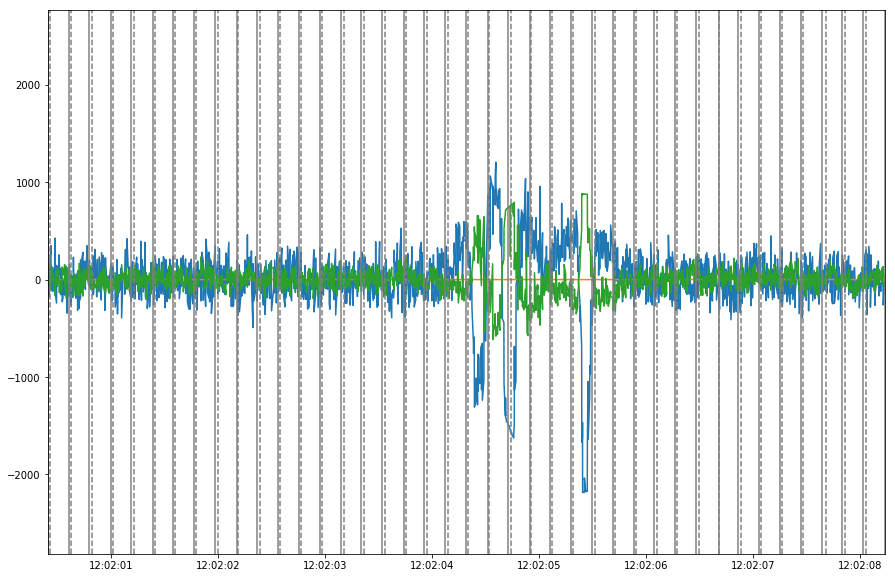

In [39]:
trial_info = df.groupby(["interval"], axis=0).first()[highlighted+[target, "timestamp"]]
trial_starts = trial_info["timestamp"]
trial_one_sec = trial_starts + datetime.timedelta(seconds=1)

pp.figure(figsize=(15,10))
pp.plot(df["timestamp"], df[channel].values)
trial_starts.map(lambda x: pp.axvline(x, color="gray", linestyle="solid"))
trial_one_sec.map(lambda x: pp.axvline(x, color="gray", linestyle="dashed"))
pp.xlim(trial_starts[10], trial_starts[50])
pp.show()

In [40]:
df.set_index("timestamp", inplace=True)

In [41]:
intervals = []
for start,end in zip(trial_starts, trial_one_sec):
    # redistribute sample points
    chunk = df[start:end][channel]
    chunk.set_index(pd.to_datetime(np.linspace(start.value, end.value, len(chunk), endpoint=True))-start, inplace=True)
    chunk = chunk.resample("4L").pad()#.interpolate(method="linear")
    intervals.append(chunk)

In [42]:
target_intervals = []
nottarget_intervals = []
for i,interval in enumerate(intervals):
    target = trial_info["target"].loc[i]
    if np.isnan(target):
        continue
    
    if trial_info[highlighted[int(target)]].loc[i]:
        target_intervals.append(interval.values)
    else:
        nottarget_intervals.append(interval.values)
        
target_intervals = np.array(target_intervals, dtype=float)
nottarget_intervals = np.array(nottarget_intervals, dtype=float)

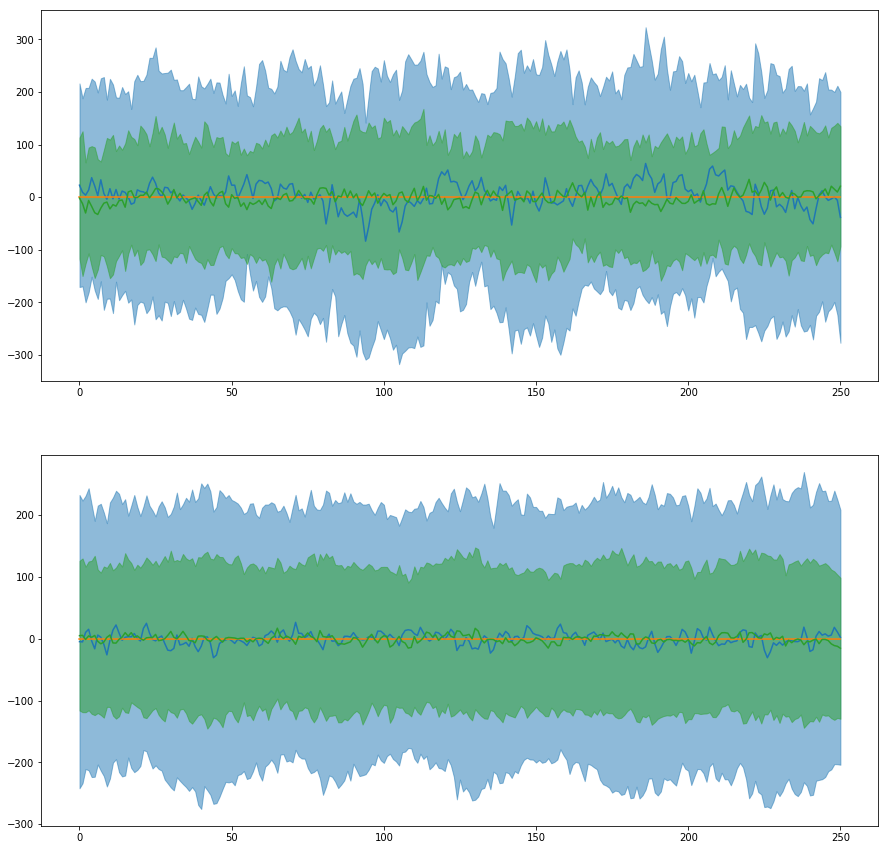

In [43]:
target_mean = target_intervals.mean(axis=0)
target_std  = target_intervals.std(axis=0)
nottarget_mean = nottarget_intervals.mean(axis=0)
nottarget_std  = nottarget_intervals.std(axis=0)

pp.figure(figsize=(15,15))
pp.subplot(211)
lines = pp.plot(target_mean)
for i,l in enumerate(lines):
    pp.fill_between(np.arange(len(target_mean)),target_mean[:,i]-target_std[:,i],target_mean[:,i]+target_std[:,i], color=l.get_color(), alpha=0.5)
pp.subplot(212)
lines = pp.plot(nottarget_mean)
for i,l in enumerate(lines):
    pp.fill_between(np.arange(len(target_mean)),nottarget_mean[:,i]-nottarget_std[:,i],nottarget_mean[:,i]+nottarget_std[:,i], color=l.get_color(), alpha=0.5)
pp.show()

In [10]:
len(target_intervals)

72